Linear Regression and Kernel Methods
====================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_matlab/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$
$\newcommand{\eqdef}{\equiv}$

This tour studies linear regression method, and its non-linear variant
using kernlization.


We recommend that after doing this Numerical Tours, you apply it to your
own data, for instance using a dataset from [LibSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/).

_Disclaimer:_ these machine learning tours are intended to be
overly-simplistic implementations and applications of baseline machine learning methods.
For more advanced uses and implementations, we recommend
to use a state-of-the-art library, the most well known being
[Scikit-Learn](http://scikit-learn.org/)

In [1]:
source("nt_toolbox/general.R")
library(plot3D)
library(pracma)


Attaching package: ‘pracma’

The following object is masked _by_ ‘.GlobalEnv’:

    circshift



Dataset Loading
---------------
We test the method on the
[Boston house prices dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html), consisting in $n=506$ samples with
features $x_i \in \RR^p$ in dimension $p=13$. The goal is to predict the price value
$y_i \in \RR$.


Helpers.

In [2]:
Xm = function(X){as.matrix(X - rep(colMeans(X), rep.int(nrow(X), ncol(X))))}
Cov = function(X){data.matrix(1. / (n - 1) * t(Xm(X)) %*% Xm(X))}

Load the dataset.

In [3]:
file_name = 'nt_toolbox/data/boston_house_prices.csv'
A = read.table(file_name, sep=",")

In [4]:
head(A)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


Randomly permute it.

In [5]:
A = A[sample(dim(A)[1]),]

Separate the features $X$ from the data $y$ to predict information.

In [6]:
X = A[,1:(dim(A)[2] - 1)]
y = A[,dim(A)[2]]

$n$ is the number of samples, $p$ is the dimensionality of the features,

In [7]:
n = dim(X)[1]
p = dim(X)[2]

Dimenionality Reduction and PCA
-------------------------------
In order to display in 2-D or 3-D the data, dimensionality is needed.
The simplest method is the principal component analysis, which perform an
orthogonal linear projection on the principal axsis (eigenvector) of the
covariance matrix.


Display the covariance matrix.

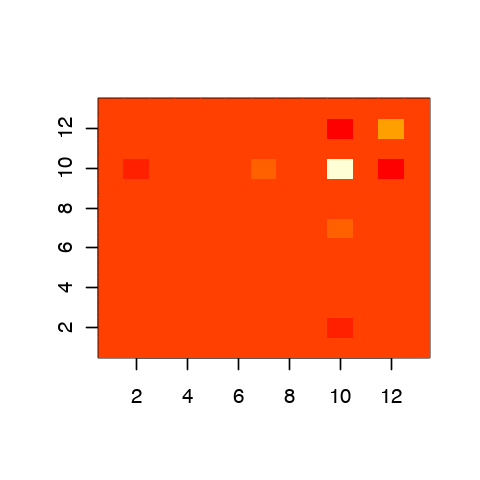

In [8]:
options(repr.plot.width=4, repr.plot.height=4)
image(c(1:p), c(1:p), Cov(X), xlab='', ylab='')

Compute PCA ortho-basis and
the feature in the PCA basis.

In [9]:
svd_decomp = svd(Xm(X))
U = svd_decomp$u
D = svd_decomp$d
V = svd_decomp$v
Z = Xm(X) %*% V

Plot sqrt of the eigenvalues.

In [10]:
diag2vec = function(M)
{
    out = c()
    diagonal = diag(M)
    for (i in 1:dim(diagonal)[1])
    {
        out = c(out, diagonal[i, i])
    }
    return(out)
}

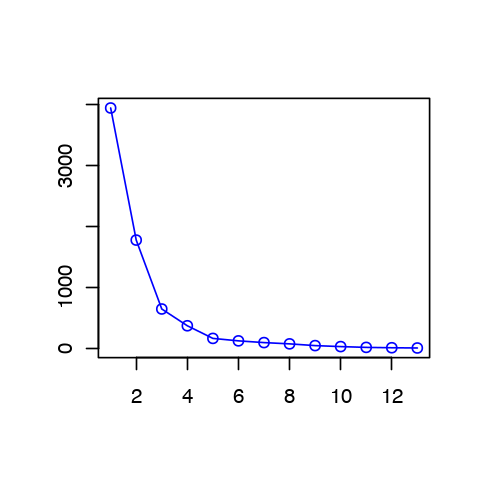

In [11]:
plot(diag2vec(D), type="o", col=4, ylab="", xlab="")

Display the points cloud of feature vectors in 3-D PCA space.

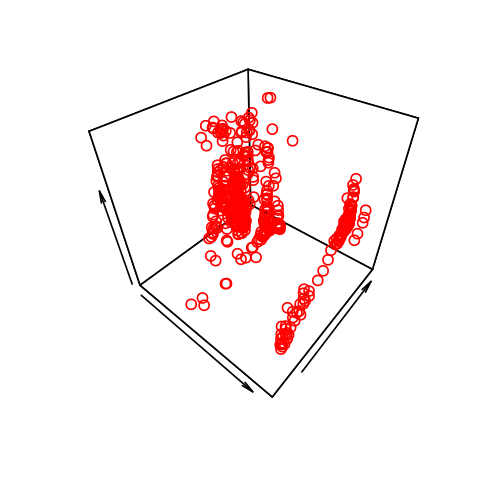

In [12]:
scatter3D(Z[,1], Z[,2], Z[,3], col=2, xlim=c(min(Z[,1]), max(Z[,1])),  
         ylim=c(min(Z[,2]), max(Z[,2])), zlim=c(min(Z[,3]), max(Z[,3])), xlab="", ylab="",
          zlab="")

1D plot of the function to regress along the main eigenvector axes.

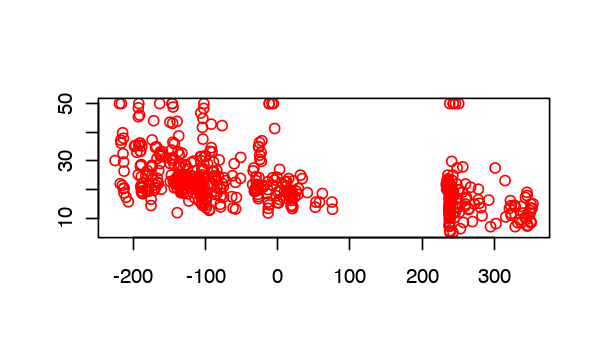

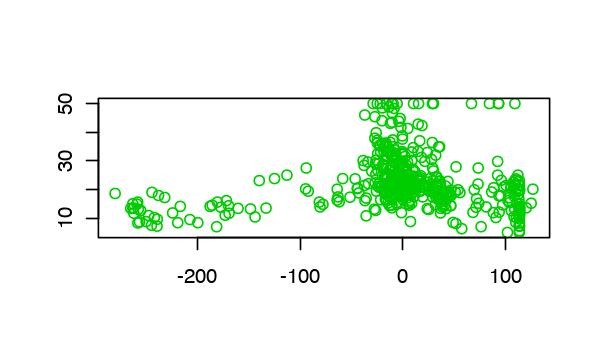

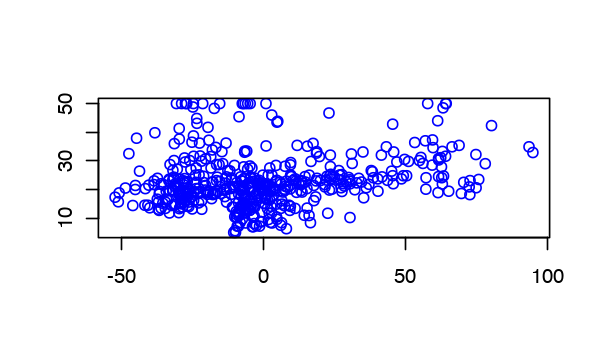

In [13]:
options(repr.plot.width=5, repr.plot.height=3)
for (i in 1:min(p,3))
{
    plot(Z[,i], y, col=i+1, xlab="", ylab="")
}

Linear Regression
-----------------
We look for a linear relationship
  $ y_i = \dotp{w}{x_i} $
written in matrix format
  $ y= X w $
where the rows of $X \in \RR^{n \times p}$ stores the features $x_i \in \RR^p$.


Since here $ n > p $, this is an over-determined system, which can
solved in the least square sense
  $$ \umin{ w }  \norm{Xw-y}^2 $$
whose solution is given using the Moore-Penrose pseudo-inverse
  $$ w = (X^\top X)^{-1} X^\top y $$



Split into training and testing.

In [14]:
n0 = round(.5 * n)
n1 = n - n0
X0 = as.matrix(X[1:n0,])
y0 = y[1:n0]
X1 = as.matrix(X[(n0+1):dim(X)[1],])
y1 = y[(n0+1):length(y)]

Least square solution.

In [15]:
w = solve(t(X0) %*% X0) %*% t(X0) %*% y0

Mean-square error on testing set.

In [16]:
E = sqrt(sum((X1 %*% w-y1)^2 ) / n1)

Regularization is obtained by introducing a penalty. It is often called
ridge regression, and is defined as
  $$ \umin{ w }  \norm{Xw-y}^2 + \lambda \norm{w}^2 $$
where $\lambda>0$ is the regularization parameter.


The solution is given using the following equivalent formula
  $$ w = (X^\top X + \lambda \text{Id}_p )^{-1} X^\top y, $$
  $$ w = X^\top ( XX^\top + \lambda \text{Id}_n)^{-1} y, $$
When $p<n$ (which is the case here), the first formula should be
prefered.


In contrast, when the dimensionality $p$ of the feature is very
large and there is little data, the second is faster. Furthermore, this
second expression is generalizable to Kernel Hilbert space setting,
corresponding possibly to $p=+\infty$ for some kernels.

In [17]:
lambda = .1
w = solve(t(X0) %*% X0 + lambda * diag(p)) %*% t(X0) %*% y0
w1 = t(X0) %*% solve(X0 %*% t(X0) + lambda * diag(n0)) %*% y0
print(paste('Error (should be 0):', round(norm(w-w1)/norm(w), 3)))

[1] "Error (should be 0): 0"


__Exercise 1__

Display the evolution of the error $E$ as a function of $\lambda$.
Display error evolution.

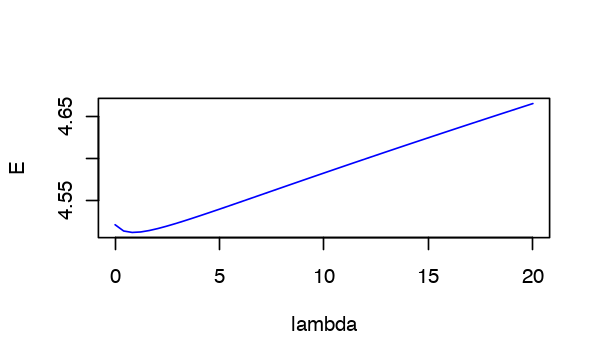

In [18]:
q = 50
lambda_list = seq(0, 20, length=q)
E = c()
W = matrix(0, q, p)

for (i in 1:q)
{
    lambda = lambda_list[i]
    w = solve(t(X0) %*% X0 + lambda * diag(p)) %*% t(X0) %*% y0
    W[i,] = w
    E = c(E, sqrt(sum((X1 %*% w - y1)^2 ) / n1))
}

# Display error evolution.
plot(lambda_list, E, type="l", col=4, xlab="lambda", ylab="E")

__Exercise 2__

Display the regularization path, i.e. the evolution of $w$ as a function
of $\lambda$.

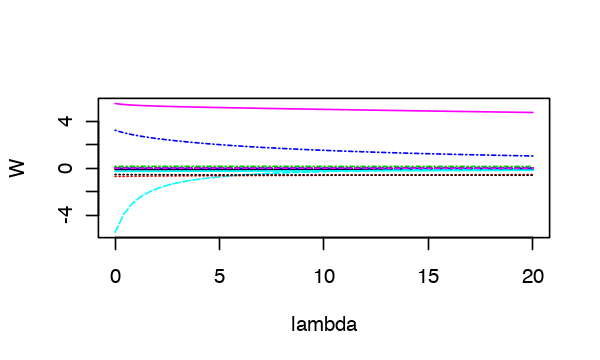

In [19]:
matplot(lambda_list, W, type="l", xlab="lambda")

__Exercise 3__

Perform feature selection using $\ell^1$ regularization (aka the Lasso),
 $$ \umin{ w }  \frac{1}{2}\norm{Xw-y}^2 + \lambda \norm{w}_1. $$

Kernelized Ridge Regression
---------------------------
In order to perform non-linear and non-parametric regression, it is
possible to use  kernelization. It is non-parametric in the sense that the number of
parameter grows with the number $n$ of samples (while for the initial
linear  method, the number of parameter is $p$). This allows in particular to
generate estimator of arbitrary complexity.


Given a kernel $ \kappa(x,z) \in \RR $ defined for $(x,z) \in \RR^p \times \RR^p$,
the kernelized method replace the linear approximation functional $f(x) =
\dotp{x}{w}$ by a sum of kernel centered on the samples
$$ f_h(x) = \sum_{i=1}^n h_i k(x_i,x) $$
where $h \in \RR^n$ is the unknown vector of weight to find.


When using the linear kernel $\kappa(x,y)=\dotp{x}{y}$, one retrieves
the previously studied linear method.


Generate synthetic data in 2D.
Add noise to a deterministic map.

In [32]:
B = 3
n = 500
p = 2
X = (2 * B * rand(n, 2)) - B
rho = .5 #noise level
y = peaks(X[,1], X[,2])$Y + randn(n, 1) * rho

Display as scattered plot.

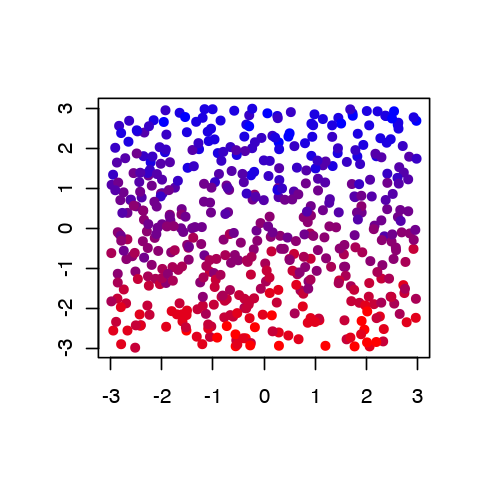

In [33]:
options(repr.plot.width=4, repr.plot.height=4)
rbPal = colorRampPalette(c('red','blue'))
col = rbPal(10)[as.numeric(cut(y,breaks=10))]

plot(X[,1], X[,2], xlim=c(-B,B), ylim=c(-B,B),
     col=col, pch=16, xlab="", ylab="")

Macro to compute pairwise squared Euclidean distance matrix.

In [34]:
distmat = function(X,Z)
{
    dist1 = diag(X %*% t(X))
    dist2 = diag(Z %*% t(Z))
    n1 = dim(X)[1]
    n2 = dim(Z)[1]
    out = matrix(0, n1, n2)
    for (i in 1:n1)
    {
        for (j in 1:n2)
        {
            out[i,j] = dist1[i] + dist2[j]
        }
    }
    out = out - 2 * X %*% t(Z)

    return(out)
}

The gaussian kernel is the most well known and used kernel
$$ \kappa(x,y) \eqdef e^{-\frac{\norm{x-y}^2}{2\sigma^2}} . $$
The bandwidth parameter $\si>0$ is crucial and controls the locality of
the model. It is typically tuned through cross validation.

In [35]:
sigma = .3
kappa = function(X,Z){exp( -distmat(X,Z)/(2*sigma^2))}

Once avaluated on grid points, the kernel define a matrix
$$ K = (\kappa(x_i,x_j))_{i,j=1}^n \in \RR^{n \times n}.  $$

In [36]:
K = kappa(X,X)

The weights $h \in \RR^n $ are solutions of
  $$ \umin{h} \norm{Kh-y}^2 + \la \dotp{Kh}{h}  $$
and hence can be computed by solving a linear system
  $$ h = (K+\la \text{Id}_n)^{-1} y  $$

In [37]:
lambda = 0.01
h = solve(K + lambda * diag(n)) %*% y

Regressor.

In [38]:
Y = function(x){kappa(x,X) %*% h}

Evaluation on a 2D grid.

In [51]:
q = 101
t = seq(-B, B, length=q);
v = as.vector(meshgrid(t, t)$X)
u = as.vector(meshgrid(t, t)$Y)
Xn = matrix(c(u, v), nrow=length(u), ncol=2)

Display as an image.

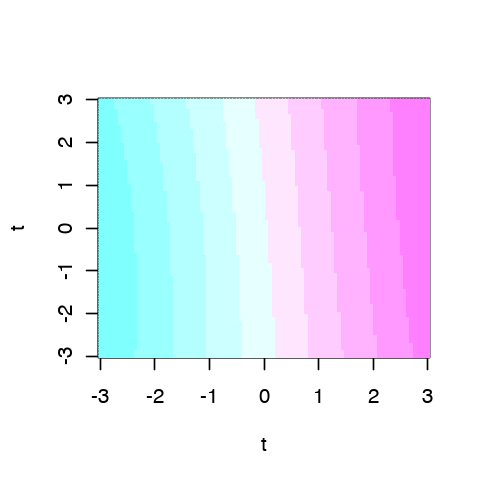

In [52]:
yn = Y(Xn)
dim(yn) = c(q, q)

__Exercise 4__

Display the evolution of the regression as a function of $\sigma$.

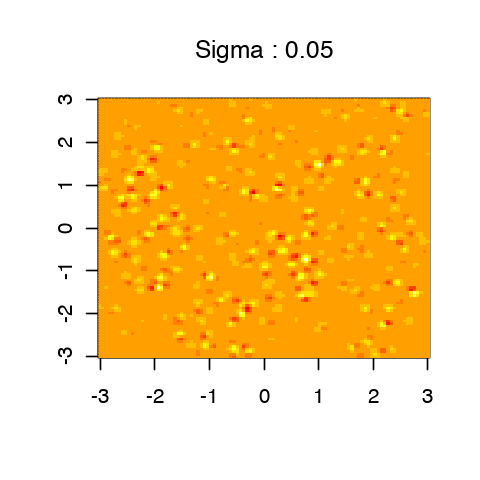

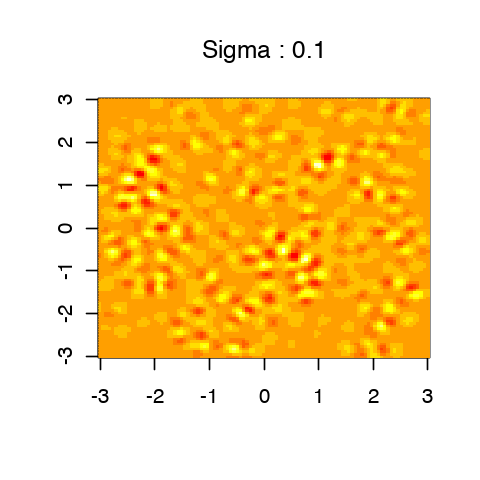

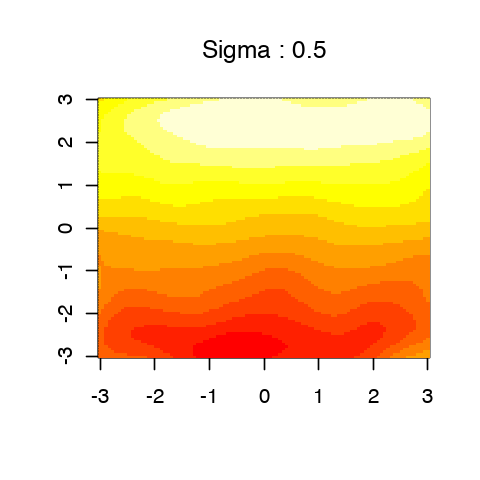

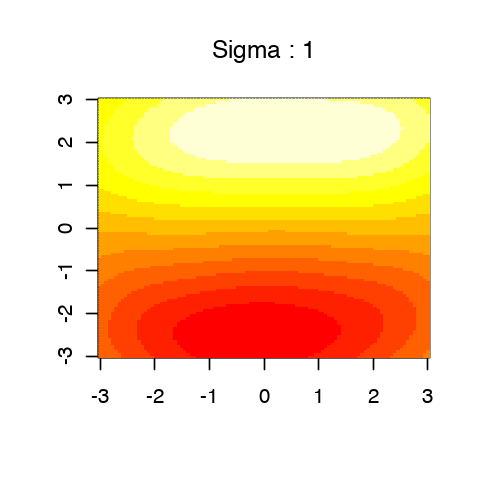

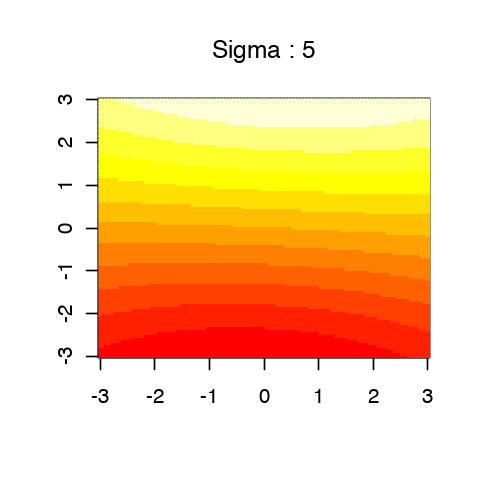

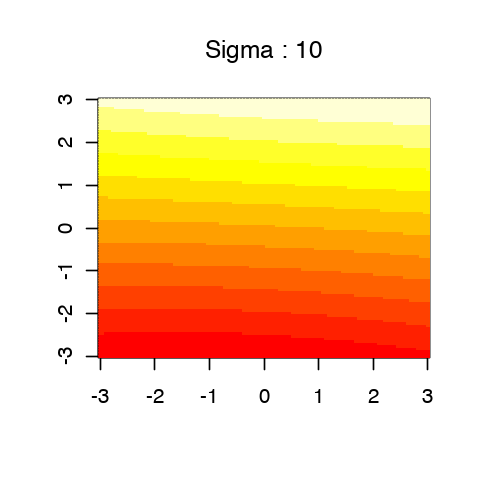

In [41]:
sigma_list = c(.05, .1, .5, 1, 5, 10)

for (i in 1:length(sigma_list))
{
    sigma = sigma_list[i]
    kappa = function(X,Z){exp( -distmat(X,Z)/(2*sigma^2))}
    # Regressor.
    h = solve(K + lambda * diag(n)) %*% y
    Y = function(x){kappa(x,X) %*% h}
    # Eval on the grid
    yn = Y(Xn)
    dim(yn) = c(q, q)
    image(t, t, yn, main=paste("Sigma :", sigma), xlab="", ylab="")
}

__Exercise 5__

Apply the kernelize regression to a real life dataset. Study the influence of $\la$ and $\si$.